# Preprocessing CGE data

In [1]:
# the following code lines are necessary to import custom module
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import boto3
import io
import json
import pandas as pd
import matplotlib.pyplot as plt
from src.preprocessing.data_preparation_and_cleaning import get_station_name
from src.preprocessing.feature_engineer import get_wind_components, resample_data, feature_engineer
from unidecode import unidecode

In [2]:
# AWS credentials to read files on S3 bucket
f = open('../credentials.json')
credentials = json.load(f)

s3_client = boto3.client(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

s3_resource = boto3.resource(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

In [3]:
# get data from S3 bucket
df_full = []
for year in list(range(2009, 2019+1)):  
    prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix=f"raw/{year}/")
    keys = [obj.key for obj in prefix_objs]
    for key in keys:
        obj = s3_client.get_object(Bucket="cge", Key=key)
        df = pd.read_csv(io.BytesIO(obj["Body"].read()))
        df_full.append(df.rename(columns={"PressÃ£o(mb)": "Pressão(mb)"}))

In [4]:
# concatenate data and selecting stations to work
cge = pd.concat(df_full, ignore_index=True)
cge = cge.drop_duplicates(ignore_index=True)
cge = get_station_name(cge)
cge[["Posto Nome"]] = cge[["Posto Nome"]].replace("NaN", "1000300")
cge = cge[cge["Posto Nome"].isin(["Sé", "Lapa", "Pirituba", "Penha", "Jabaquara", "Parelheiros"])]
cge = cge.drop(["Bateria(V)", "Sens. Térmica(°C)"], axis=1)
cge.head()

,Posto,DATA,PLU(mm),Vel.VT(m/s),Dir.VT(o),Temp(oC),Umid.Rel.(%),Pressão(mb),Rajada.VT(m/s),Posto Nome
447554,1000848,2010-04-01 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447555,1000848,2010-04-01 19:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447556,1000848,2010-04-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447557,1000848,2010-04-01 20:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447558,1000848,2010-04-01 20:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa


In [5]:
# renaming columns
cge.columns = [
    "station",
    "timestamp",
    "precipitation",
    "wind_velocity",
    "wind_direction",
    "temperature",
    "relative_humidity",
    "pressure",
    "wind_blow",
    "station_name"
    ]

cge.head()

,station,timestamp,precipitation,wind_velocity,wind_direction,temperature,relative_humidity,pressure,wind_blow,station_name
447554,1000848,2010-04-01 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447555,1000848,2010-04-01 19:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447556,1000848,2010-04-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447557,1000848,2010-04-01 20:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa
447558,1000848,2010-04-01 20:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lapa


In [6]:
# feature engineer and write data on S3 bucket
dfs = {}
for station in ["Sé", "Lapa", "Pirituba", "Penha", "Jabaquara", "Parelheiros"]:
    df = cge[cge.station_name == station]
    df = df.dropna(axis=1, how="all")
    df = df.reset_index(drop=True) 

    try:
        df = get_wind_components(
            df=df, 
            wind_velocity="wind_velocity", 
            wind_direction="wind_direction", 
            x_name="wind_velocity_x", 
            y_name="wind_velocity_y"
            )

        df = get_wind_components(
            df=df, 
            wind_velocity="wind_blow", 
            wind_direction="wind_direction", 
            x_name="wind_blow_x", 
            y_name="wind_blow_y"
            )

        df = df.drop(["wind_velocity", "wind_blow", "wind_direction"], axis=1)
    except:
        pass

    df = resample_data(df)
    df = df.reset_index()
    df = df.set_index("timestamp")
    to_drop = ["station", "station_name"]
    cols = list(df.drop(to_drop, axis=1).columns)
    df = feature_engineer(df=df, features=cols, lags=12, window=12)
    cols.remove("temperature")
    df = df.drop(cols, axis=1)
    
    # writing data to dict
    station_ = unidecode(station.lower().replace(" ", "_"))
    dfs[station_] = df

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule="60min").mean()
/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule="60min").mean()
/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule

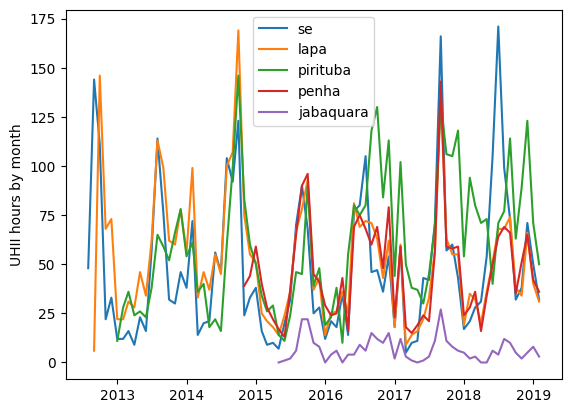

In [19]:
def count_delta_five(x):
        if x >= 5:
            return 1
        else: 
            return 0

dfs_delta = {}
for k, v in dfs.items():
    if k != "parelheiros":
        urban_temp = dfs[k][["temperature"]].dropna().rename(columns={"temperature": "temperature_urban"})
        rural_temp = dfs["parelheiros"][["temperature"]].dropna().rename(columns={"temperature": "temperature_rural"})
        uhii = rural_temp.merge(urban_temp, left_index=True, right_index=True)
        uhii["uhii"] = uhii.temperature_urban - uhii.temperature_rural
        uhii["uhii_delta_five"] = uhii["uhii"].apply(count_delta_five) 
        uhii["year"] = uhii.index.year.astype(str)
        uhii["month"] = uhii.index.month.astype(str).str.rjust(2, "0")
        uhii["ym"] = uhii["year"] + uhii["month"]
        uhii_grouped = uhii[["ym", "uhii_delta_five"]].groupby("ym").sum().reset_index()
        uhii_grouped["ym"] = pd.to_datetime(uhii_grouped["ym"], format="%Y%m")
        uhii_grouped = uhii_grouped.set_index("ym")
        uhii_grouped["station"] = k
        dfs_delta[k] = uhii_grouped 

for k, v in dfs_delta.items():
    plt.plot(dfs_delta[k][["uhii_delta_five"]], label=k)
plt.ylabel("UHII hours by month")
plt.legend()
plt.show()
